In [1]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [3]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 100 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100
GLOVE_DIR = r"glove.twitter.27B.100d.txt"

In [4]:
import os 
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DATASET AML/')

Mounted at /content/drive


# Import Glove

In [5]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")


Loading GloVe from: glove.twitter.27B.100d.txt ...Done.
 Proceeding with Embedding Matrix...

Mounted at /content/drive


#Import Dataset

EDA BINARY

In [6]:
os.chdir('/content/drive/My Drive/DATASET AML/PROJECT/dataset_giusti')

In [7]:
train = pd.read_csv("MULTILABEL_augmented_Trans_senza_stopword_FINAL.csv")
train["comment_text"] = train["comment_text"].astype(str)
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,well know faggot gonna ya little bitch,1,1,1,0,1,1
1,fuck fuck fuck fuck fuck fuck fuck fuck fuck f...,1,0,1,0,0,0
2,god god god would mention one big thing people...,0,0,1,0,0,0
3,ml outrage listen league xbox not nextgen bc u...,1,0,0,0,0,0
4,real bastard spy pinarayi work pinarayi oneday...,1,1,1,0,1,0


#Tokenization and Embedding

In [8]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train['comment_text'].values)
sequences = tokenizer.texts_to_sequences(train["comment_text"])
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 32790


In [9]:
embeddings_dict = {}

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_dict[word] = embedding_vector
print(" Completed!")

 Completed!


In [10]:
tsne = TSNE(n_components=2, random_state=0)
words =  list(embeddings_dict.keys())
vectors = [embeddings_dict[word] for word in words]

In [11]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [12]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

In [13]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (19697, 100)
Shape of label tensor: (19697, 6)


In [14]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [15]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [14893  2897  9063   931  8551  2612]
validation:  [3741  712 2231  232 2160  605]


In [16]:
print('Tokenized sentences: \n', data[20])
print('One hot label: \n', labels[20])

Tokenized sentences: 
 [694 928   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
One hot label: 
 [1 0 1 0 0 0]


In [17]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

 Completed!


#GRU MODEL

In [100]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

In [101]:
import keras

In [102]:
from tensorflow.keras.layers import Bidirectional

In [103]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = (Bidirectional(GRU(128, return_sequences=False, name='gru_layer')))(embedded_sequences)
#x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

In [104]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = [tf.keras.metrics.Recall()])

In [105]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 4, batch_size=128, validation_data=(x_val, y_val), verbose = 2, callbacks=[callback])

Training progress:
Epoch 1/4
124/124 - 5s - loss: 0.3988 - recall_5: 0.7418 - val_loss: 0.3333 - val_recall_5: 0.8026
Epoch 2/4
124/124 - 2s - loss: 0.3314 - recall_5: 0.7906 - val_loss: 0.3092 - val_recall_5: 0.8411
Epoch 3/4
124/124 - 2s - loss: 0.3098 - recall_5: 0.8131 - val_loss: 0.2952 - val_recall_5: 0.8272
Epoch 4/4
124/124 - 2s - loss: 0.2995 - recall_5: 0.8206 - val_loss: 0.2900 - val_recall_5: 0.8195


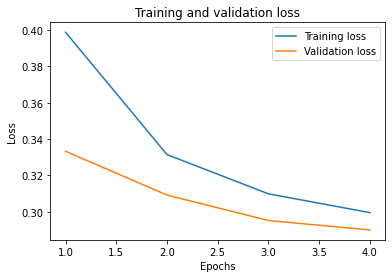

In [106]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

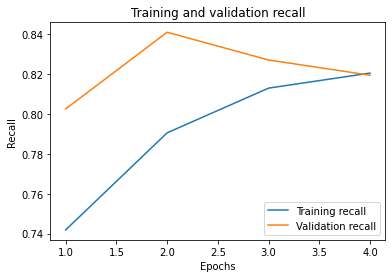

In [112]:
accuracy = history.history['recall_5']
val_accuracy = history.history['val_recall_5']
plt.plot(epochs, accuracy, label='Training recall')
plt.plot(epochs, val_accuracy, label='Validation recall')
plt.title('Training and validation recall')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Test

In [26]:
os.chdir('/content/drive/My Drive/DATASET AML/PROJECT/dataset_giusti/TEST')

In [27]:
test = pd.read_csv("test_multilabel_senza_stopword.csv")

In [28]:
test

,Unnamed: 0,Unnamed: 0.1,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,8,21,arab commit genocide iraq protest europe may e...,1,0,0,0,0,0
1,24,48,dj robinson gay hell suck dick much,1,0,1,0,1,1
2,29,59,fuck antisemitic cunt,1,0,1,0,1,0
3,38,76,dare vandalize page hm beagle not vandalize demon,1,0,0,0,0,0
4,40,81,arrogant self serve immature idiot get right,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
6238,63877,152908,nigel crazy idiot,1,0,0,0,1,0
6239,63935,153049,well not feel stupid,0,0,0,0,1,0
6240,63945,153078,fourth baldrick possibly cleverer make anyone ...,1,0,0,0,0,0
6241,63962,153119,iran thats right iran drone spread homosexual ...,1,0,1,0,0,0


In [29]:

sequences = tokenizer.texts_to_sequences(test["comment_text"].astype(str))


In [30]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [31]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = test[labels].values

In [113]:
eval= model.evaluate(data,y)

196/196 [==============================] - 1s 7ms/step - loss: 0.2737 - recall_5: 0.8380


In [114]:
performance = model.predict(data)


In [115]:
import sklearn
y_pred =np.round(performance)
print("RECALL: ", sklearn.metrics.recall_score(y, y_pred, average= 'weighted'))
print("PRECISION: ",sklearn.metrics.precision_score(y, y_pred, average= 'weighted'))
print("F1-SCORE: ",sklearn.metrics.f1_score(y, y_pred, average= 'weighted'))



mat =sklearn.metrics.multilabel_confusion_matrix(y,y_pred)
accuracy=[]
for i in range(mat.shape[0]):

  accuracy.append((mat[i][1][1]+mat[i][0][0])/(mat[i][1][1]+mat[i][0][0]+mat[i][0][1]+mat[i][1][0]))

def Average(lst): 
    return sum(lst) / len(lst) 

accuracy_media =  Average(accuracy) 
print("ACCURACY: ",accuracy_media)


RECALL:  0.8380466271209822
PRECISION:  0.8495133189351631
F1-SCORE:  0.8429840688618777
ACCURACY:  0.8803993806396497
